
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [109]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import re
from sklearn.model_selection import train_test_split
from seaborn import countplot

In [3]:
tf.test.gpu_device_name()

''

<font size=4>Grader function 1 </font>

In [4]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [93]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"/content/drive/MyDrive/Assignments/BERT/Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [94]:
data=pd.DataFrame()
data['Text']=reviews.Text.values
data['Score']=reviews.Score.values

In [95]:
data['Text'].isnull().values.any()

False

In [96]:
data['Score'].isnull().values.any()

False

In [97]:
reviews=data[data.Score!=3]

In [98]:
reviews.shape

(525814, 2)

In [99]:
s=[]
for i in reviews.Score.values:
  if i<=2:
    s.append(0)
  else:
    s.append(1)

In [100]:
reviews=reviews.drop('Score',axis=1)
reviews['Score']=s

reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


<font size=4>Grader function 2 </font>

In [101]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [102]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [103]:
reviews.shape

(100000, 3)

In [104]:
t=list(reviews.Text.values)
text=[]
for i in tqdm(t):
  i=BeautifulSoup(i,'lxml').get_text()
  """i=decontracted(i)
  i=re.sub("\S*\d\S*", "", i).strip()
  i=re.sub('[^A-Za-z0-9]+', ' ', i)
  i=re.sub(r"http\S+", "", i)
  i=re.sub('[^A-Za-z]+', ' ', i)"""
  text.append(i)






/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
reviews=reviews.drop('Text',axis=1)
reviews["Text"]=text

In [106]:
reviews.head()

,Score,len,Text
64117,1,30,The tea was of great quality and it tasted lik...
418112,1,31,My cat loves this. The pellets are nice and s...
357829,1,41,Great product. Does not completely get rid of ...
175872,1,27,This gum is my favorite! I would advise every...
178716,1,22,I also found out about this product because of...


In [108]:
x=reviews.Text.values
y=reviews.Score.values
X_train,X_test,Y_train,Y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=33)

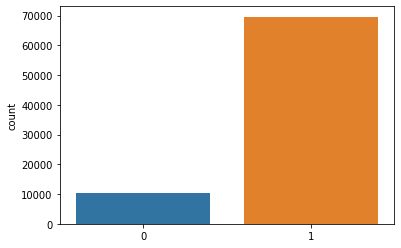

In [111]:
countplot(x=Y_train)

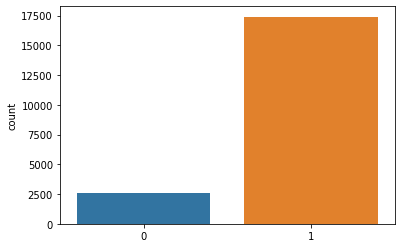

In [112]:
countplot(x=Y_test)

In [ ]:
#plot bar graphs of y_train and y_test

In [114]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('/content/drive/MyDrive/Assignments/BERT/preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [115]:

tf.keras.backend.clear_session()


max_seq_length = 55


input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")


input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")


segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")


bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])


bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [116]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [117]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [118]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [124]:
import sys  
sys.path.insert(0, '/content/tokenization.py')

py -m pip install "tokenization.py"

SyntaxError: ignored

In [ ]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation

<font size=4>Grader function 3 </font>

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [ ]:
import pickle

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
#you can load from disk
#X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
#X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [ ]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

<font size=4>Grader function 5 </font>

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
bert_model.input

In [ ]:
bert_model.output

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
#X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [ ]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric.</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [ ]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

In [ ]:
##create an NN and 


<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 

1. Download data from <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a>
2. Read the csv file
3. Remove all the html tags
4. Now do tokenization [Part 3 as mentioned above]
    * Create tokens,mask array and segment array
5. Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
   * Print the shape of output(X_test.shape).You should get (352,768)
6. Predit the output of X_test with the Neural network model which we trained earlier.
7. Print the occurences of class labels in the predicted output

</pre>